# Word2Vec 词嵌入
上一篇中我们了解到可以通过在神经语言模型中加入词嵌入层的方法，在训练网络的概率函数的同时也训练出一套词嵌入参数。但是在更多的情况下，我们只想要一套优秀的词嵌入矩阵，而于此无关的复杂计算我们都希望能尽可能的减少。因此谷歌提出的Word2Vec模型（准确的说是Skip-gram方法）就可以用最快的方法在更大的语料库中训练一套含义丰富的词嵌入模型
## 训练集的设置——skip-gram和cbow方法
现在有一句话“The quick brown fox jumps over the lazy dog”, 我们希望能够学习里面的词语和词语之间的关系。在这里我们有两种构建输入-输出数据对的方法cbow和skip-gram

这两种方法都需要使用一个滑动窗口，每次在不同的位置附近连续的选择几个词语，把它们之间的联系输入网络。设想我们现在取到了这样五个词语：“quick brown fox jumps over”，那么我们对于CBOW方法和Skip-gram方法有不同的处理方式：
### CBOW
对于CBOW方法，我们每次选择窗口中间的一次词语，把其余的词语作为网络的输入，我们希望网络可以预测我们选中的词语，那么我们构建的数据对就有可能是这样的`("quick", "brown", "jumps", "over") -> ("fox“)`
### Skip-gram
而当我们使用Skip-gram方法时，我们会选中一个词语，然后让网络尝试预测它的上下文词语。那么我们就会构造出这些数据对：`("fox") -> ("quick")`,`("fox") -> ("brown")`,`("fox") -> ("jumps")`,`("fox") -> ("over")`

事实证明，这两种方法都可以促使网络学习到一个不错的词嵌入向量。实践时，我们会利用到目标词和上下文词语的词向量，这时我们会把CBOW中所有上下文词语的词向量求平均值后再输入网络，这样CBOW和Skip-gram都是单个输入对应单个输出的任务了，我们可以用完全一样的网络在这两种方法构造的数据集上训练。而由于CBOW把上下文词向量求了平均值，可以看作是对词语分布的平滑处理，CBOW更适合于那些数据分布本来就比较不稳定的规模较小的数据集上训练，而Skip-gram则更适合于大的数据集

这两种采样方法的实现在loader.py里面，下面我们就直接调用里面的函数，由于数据集比较小，之后的内容中会使用CBOW来进行训练

In [1]:
from loader import get_dataloader
cbow_dataloader = get_dataloader("cbow", batch_size = 128, window_size=5, lines_limit=10000)
skip_dataloader = get_dataloader("skip", batch_size = 128, window_size=5, lines_limit=10000)

Initializing vocabulary...
Loading Yahoo dataset...
Counted 49734 words in  dataset


## Word2Vec模型实现
接下来我们只需要设计一个可以接受一个或多个单词输入，预测一个单词输出的网络模型就可以了。当然可以直接用神经语言模型来做这件事，但是这个方案有两个问题：

1. 既然网络的唯一目的就是训练一套词嵌入参数，那么我们就要尽可能简化网络，只保留最关键的部分，而神经语言模型还是太复杂了
2. 大的词嵌入模型需要为$10^5 \sim 10^7$词语设计向量，在这么大的词语规模下，我们怎么选中那个要预测的词语？用SoftMax输出字典中每一个词语的概率吗？显然不现实。因此我们需要更好的方法。

这里有三种模型可供选择，直接用SoftMax的模型，使用Hierarchical SoftMax的模型，使用Negative Sampling负采样的模型
### 使用SoftMax的模型
这个模型解决了网络不必要的复杂的问题但是没有解决SoftMax速度慢的问题，它的逻辑很简单：我们语料库中的每一个词语都对应一个词嵌入向量$v_w$和参数向量$\theta_w$，其中词嵌入向量是我们希望能够训练出的有意义的向量，而参数向量只是网络里用来对其他嵌入向量进行变换的网络参数。我们对于任意输入词$w_I$和需要预测的输出词$w_O$，有如下定义：
$$P(w_O|w_I) = SoftMax(\theta_{w_O}^Tv_{w_I}) = \frac{\exp(\theta_{w_O}^Tv_{w_I})}{\sum_w^W \exp(\theta_{w}^Tv_{w_I})}$$
在Skip-gram中，$w_I$就是选中的目标词语，$w_O$就是需要预测的附近的其他词语。在CBOW中，$w_O$就是需要预测的目标词语，但是用多个上下文词语的嵌入向量的平均值作为$v_{w_I}$
可以看到，要最大化$P(w_O|w_I)$，不仅要算出$\exp(\theta_{w_O}^Tv_{w_I})$，还要算出$\sum_w^W \exp(\theta_{w}^Tv_{w_I})$，这计算量实在是太大了

In [2]:
# Train on a very small dataset with SoftMax
import torch
import torch.nn as nn
import loader
from loader import initVocab, get_dataloader
from model import Word2VecSM
from utils import Timer

# Each time lines_limit changes, vocab need to be reload
initVocab(lines_limit=800)
cbow_dataloader = get_dataloader("cbow", batch_size = 32, window_size=5, lines_limit=800)
vocab_size = len(loader.vocab)
embedding_dim = 100
log_interval = 300
running_loss = 0

# Uses Word2Vec with SoftMax to train
model = Word2VecSM(vocab_size, embedding_dim)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Training start with SoftMax Word2Vec")
for idx, batch in enumerate(cbow_dataloader):
    input, target = batch
    output = model(input)
    optimizer.zero_grad()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if idx % log_interval == log_interval - 1:
        print("Step %d:\tloss=%.3f\t%s" % (idx, running_loss/log_interval, Timer.Now()))
        running_loss = 0
print("Finish Training")
Timer.Stop()

Initializing vocabulary...
Loading Yahoo dataset...
Counted 10923 words in  dataset
Training start with SoftMax Word2Vec
Loading Yahoo dataset...
Step 299:	loss=16.914	0m:0s
Step 599:	loss=14.707	0m:4s
Step 899:	loss=13.160	0m:8s
Step 1199:	loss=12.136	0m:13s
Step 1499:	loss=11.339	0m:17s
Step 1799:	loss=10.777	0m:22s
Step 2099:	loss=10.215	0m:26s
Step 2399:	loss=9.639	0m:31s
Finish Training


### 使用Hierarchical SoftMax的模型
这是一种使用二叉树结构减少计算概率的计算量的方法：

![1*dI7tiRsPrwYfw4zcukRHog](https://image.panwenbo.icu/blog20210716211151.png)

如上图所示，这棵二叉树中的叶子就是一个词汇表里的单词，每个非叶节点都是一个小逻辑回归网络，这些网络可以接受一个上下文词语$w_I$输入，输出一个概率，表示如果这个上下文词语可以映射到一个目标词语$w_O$(就像我们的数据集里定义的那样),那么这个词语$w_O$出现在其右子树中的概率。设某一个节点的参数为$\theta_k$，那么我们就有：
$$P(w_O \text{ in right subtree given context } w_I) = \sigma(\theta_k^T v_{w_I})$$
$$P(w_O \text{ in left subtree given context } w_I) = 1 - \sigma(\theta_k^T v_{w_I})$$
这个$w_O$可以随意指定，我们可以计算任选的一个$w_O$是上下文词语$w_I$对应词语的概率。如果我们想要计算某一个$w_O$是上下文词语$w_I$对应词语的概率，我们只需要首先找出从根节点到$w_O$的唯一路径，把$w_I$带入路径中每一个节点的网络，把它们得到的概率或连续累乘，或变成1-P后再乘进去（如果这里需要向左子树前进的话），最终我们得到的乘积就是我们需要的概率。可以证明，对于同一个$w_I$，用这种方式得到的所有$P(w_O|w_I)$之和为1.
Hierarchical SoftMax有以下特点：

1. 这棵树如果有V个叶子，他就有V-1个节点和V-1个$\theta_k$作为参数。而直接使用SoftMax分类则需要V个$\theta_w$参数，总量上是差不多的。但是可知现在计算一个单词的概率需要的计算次数平均不超过$\log_2 V$次， 速度大大加快了。
2. 为了使得每个词语到根节点的距离尽可能小，可以使用一个平衡二叉树来减小树的高度；如果我们希望被频繁访问的词语的深度更小，还可以构建一个哈夫曼树来根据词语频率调节不同叶子深度。当然这里的实现两种方法都没有采用（实现起来太复杂了），采用的是直接构建一个完全二叉树，因为这样可以用一个数组来存下所有节点网络。
3. 如果想用这个网络计算最高概率的词汇，那可没有偷懒的余地了——每次都沿着概率最高的那个子树前进并不能得到什么有意义的结果，还是需要计算所有的节点概率，考虑每个叶子节点。
4. 可以看到，计算不同的词语需要在树中走过不同的路径，于是想要在这个网络中使用mini-batch需要保证batch里的$w_O$都是一样的，因为这个原因，在最后的实现中也不会使用Hierarchical SoftMax方法。

最后得$P(w_O|w_i)$以后，我们使用交叉熵损失函数计算损失即可：
$L = -\log(P(w_O|w_I;\theta))$ 但是在这里使用完全二叉树的一个问题是部分概率会由于大量连乘精度下溢变成0，于是实践中我用路径上多个负对数Sigmoid概率连加代替了连乘来防止溢出。

下面的内容是使用层级SoftMax方法进行的简单的训练，有意思的是，Hierarchical SoftMax显著的慢于普通SoftMax，而且收敛的速度也非常慢。我认为的原因有两点：

1. 这里的Hierarchical SoftMax的实现在batch方向上是用了for循环来做，因为不同的$w_O$的计算路径是不一样的，不易向量化，而普通SoftMax的输出也就是10000左右多分类，还没到严重拖慢算法的程度。
2. Hierarchical SoftMax是一个多层网络，这10000多个叶子带来的树深度大约有13层，并且相对于普通SoftMax每次可以训练到所有参数，它的迭代每次只能训练很小一部分参数，这也导致收敛速度变慢。


In [ ]:
# Train on a very small dataset with Hierarchical SoftMax
import loader
from loader import initVocab, get_dataloader
import torch
import torch.nn as nn
from model import Word2VecHSM
from utils import Timer

# Each time lines_limit changes, vocab need to be reload
initVocab(lines_limit=800)
cbow_dataloader = get_dataloader("cbow", batch_size = 32, window_size=5, lines_limit=800)
vocab_size = len(loader.vocab)
embedding_dim = 100
log_interval = 300
running_loss = 0

# Train with Word2Vec with Hierachical SoftMax
# There is no need to set up a loss function because the model directly returns the sum of loss.
model = Word2VecHSM(vocab_size, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Training start with Hierarchical SoftMax")
for idx, batch in enumerate(cbow_dataloader):
    input, target = batch
    loss = model(input, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if idx % log_interval == log_interval - 1:
        print("Step %d:\tloss=%.3f\t%s" % (idx, running_loss/log_interval, Timer.Now()))
        running_loss = 0
print("Finish Training")
Timer.Stop()

### Negative smapling 负采样方法
优化SoftMax的实质是增大正确的预测的概率，缩小错误的预测的概率，而负采样方法正是显式的把这个过程拿上台面，变成了一个二分类问题。我们仅计算$P(w_O|w_I)=\sigma(\theta_{w_O}^Tv_{w_I})$，并希望它尽可能的大，但是为了防止网络退化成一个无论任何输入都输出1的网络，我们再对于每个$w_I$，从语料库中随机采样出k个词语$w_R$，这些词语由于是从茫茫词海中随机选到的几个词语，这k个词语几乎和$w_I$不会有任何关联，因此我们希望$P(w_R|w_I)=\sigma(\theta_{w_R}^Tv_{w_I})$可以尽可能的小。

实践显示，在小的训练集中，k取5到20之间是比较合适的，而在大的训练集中，k取到2到5之间也是很好的。

#### 如何采样$w_R$

这里有两种采样方式，均匀采样（Uniform Sampling）和按频率采样（或者叫一元模型采样Unigram Sampling， $w_R \sim U(w)$），经过研究显示，U(w)的3/4次方可以既考虑到高频词汇的重要性又兼顾到低频词汇，可以达到最好的表现，于是最佳的设置就是$w_R \sim \frac{U(w)}{Z}$，其中除以Z是为了归一化分布。

#### 如何采样$w_I$

这个问题不仅适用于负采样，也是SoftMax等方法需要考虑的。如果随机地在语料库中大量采样，那么“the”，“a“等词语可能会被处理上百万次，但是我们可能更希望多处理一些有意义的词语对比如（Paris,France）而不是（The,France）。于是我们使用以下公式进行权衡：
$$P(w_I) = 1 - \sqrt{\frac{t}{f(w_I)}}$$
更多的细节建议参考原论文，下面的实现使用最简单的从语料库中随机采样$w_I$，从词语库中均匀采样$w_R$。训练使用Skip-gram获取词语对。下面我们训练一个简单的词嵌入算法，这个算法我们就随便训练意思一下，可能是由于数据集过小的原因，事实上，训练出的词向量并不能有效的支持我们展开下面的实验。


In [24]:
# Experiment with Negative sampling, skip-gram.
# Train on a slightly larger dataset, but still small
import loader
from loader import initVocab, get_dataloader
import torch
import torch.nn as nn
from model import Word2VecNSLoss
from utils import Timer

# Each time lines_limit changes, vocab need to be reload
initVocab(lines_limit=5000)
vocab_size = len(loader.vocab)
embedding_dim = 50
batch_size = 128
log_interval = 60

num_epoches = 1
K = 2 # Number of negative samples

# Train with Word2Vec with Word2Vec with Negative Sampling
# There is no need to set up a loss function because the model directly returns the average loss.
model = Word2VecNSLoss(vocab_size, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

print("Training start with Negative Sampling")
Timer.Start()
for epoch in range(num_epoches):
    # dataloader cannot be reused, must be reset each epoch.
    running_loss = 0
    skip_dataloader = get_dataloader("skip", batch_size = 128, window_size=5, lines_limit=50)
    for idx, batch in enumerate(skip_dataloader):
        input, pos_context = batch
        input = input.view((-1, 1))
        pos_context = pos_context.view((-1, 1)) # (Batch_size, 1)

        # Don't use K * batch_size, because dataloader can't guarantee the size of batch.
        neg_context = torch.randint(vocab_size, (K*input.size(0), 1))

        loss = model(input, pos_context, neg_context)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if idx % log_interval == log_interval - 1:
            print("Epoch:%d \tStep: %d\tloss=%.3f\t%s" % (
                epoch + 1, 
                idx, 
                running_loss/log_interval, 
                Timer.Remain(percent=epoch/num_epoches)))
            running_loss = 0
print("Finish Training")
Timer.Stop()

Initializing vocabulary...
Loading Yahoo dataset...
Counted 32067 words in  dataset
Training start with Negative Sampling
Loading Yahoo dataset...
Finish Training


## 可视化词向量
接下来进行几个单词位置的可视化，根据给出的几个单词进行PCA处理，取出方差最大的两个方向，显示它们的坐标。可以看出，词嵌入向量之间的平行四边形关系和聚类特点很明显的表现出来了。首都对国家成平行四边形关系，东方国家和西方国家之间有聚类的特点。不过首先我们需要先导入一个已经训练好的Glove词嵌入算法数据。

In [65]:
model = torch.load("word2vec.model")

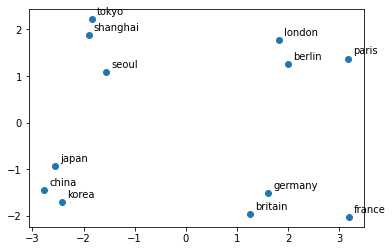

In [70]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Turns a string into a embedding vector
word2idx = lambda x: loader.vocab[loader.tokenizer(x)[0]]
idx2vec = lambda x: model.input_embedding(torch.tensor(x).long().view(1, 1))
word2vec = lambda x: idx2vec(word2idx(x))

# Pays attention to whether these words appear in vocabulary first!
words = ["berlin", "germany",
         "paris", "france",
         "shanghai", "china",
         "london", "britain",
         "seoul", "korea",
         "tokyo", "japan"]
embeddeds = [word2vec(w) for w in words]
X = torch.cat(embeddeds, dim=0).detach().numpy()

# Uses PCA method to narrow the dimensions of embedding vector down
pca = PCA(n_components=2)
pca.fit(X)
X_new = pca.transform(X)
x = X_new[:, 0]
y = X_new[:, 1]

# Plot and annotation
plt.scatter(x, y,marker='o')
for i in range(len(x)):
    plt.annotate(words[i], xy = (x[i], y[i]), xytext = (x[i]+0.1, y[i]+0.1))
plt.show()

## 寻找对应的词向量
这个实验是在所有的词向量中寻找“男孩”相对于“女孩”相当于“国王”相对于“女王”的关系。

In [71]:
from tqdm import tqdm # Displays progress bar
from loader import vocab

input_word1 = "go"
input_word2 = "went"
output_word1 = "think"
output_word2 = "<unk>"
output_idx = 0

# Checks whether all words appears in vocabulary
for w in [input_word1, input_word2, output_word1]:
    if vocab[w] == vocab["<unk>"]:
        print("The word %s doesn't appear in vocabulary" % w)

# Finds a output_word2 that is closest to input_word2 - input_word1 + output_word1
target_tensor = word2vec(input_word2) - word2vec(input_word1) + word2vec(output_word1)
for i in tqdm(range(vocab_size)):
    if not vocab.lookup_token(i) == input_word2 and\
       not vocab.lookup_token(i) == output_word1 and\
       torch.abs(idx2vec(i)-target_tensor).sum() < torch.abs(idx2vec(output_idx)-target_tensor).sum():
        output_idx = i
        output_word2 = vocab.lookup_token(i)

print("\n%s to %s is %s to (%s)" % (input_word1, input_word2, output_word1, output_word2))

100%|██████████| 32067/32067 [00:05<00:00, 6381.87it/s]


go to went is think to (thought)
